In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MABarbadillo/
%cd 'GWP/GWP files'
import os

In [ ]:
##Install rosetta

!pip install rosetta-soil
from rosetta import rosetta, SoilData

In [3]:
#### Version_1.0
#### Comparing hydraulic conductivity values using K0 + L + Rosetta 1 parameters with values obtained using K0 + L=0.5 + Rosetta 3 parameters
#### Using the percent sand, silt, clay, bulk density, and volumetric water contents at -33 and -1500 kPa from 'MesoSoilv1_3.csv' file
#### Using matric potential data from 'longtermmeans.csv' file in the 'Mesotoobox - MesoSoilv1_3 Database' folder
#### Data were from 125 Mesonet sites at depths 5, 25, and 60 cm from 1998 to 2014 (long term mean).

import numpy as np   #Library that helps in numerical calculations
import pandas as pd  #Library used for handling structured data
                     #In this case, pandas read the csv file and convert the data into data frame (i.e., tables with rows and columns)

# Read the 'MesoSoilv1_3.csv' file, skipping the first row and using the second row as header
df = pd.read_csv('/content/drive/MyDrive/MABarbadillo/GWP/GWP files/MesoSoilv1_3.csv', header=0, skiprows=1)

# Extract the data from the specified columns
# In python, rows and columns start at 0
# .iloc is used for integer-location based indexing
# .tolist() converts the selected portion of the data frame into nested list format which is more flexible and covenient
# From the data frame, values needed are from depths 5, 25, and 60 which are all in odd rows
# 1::2 specifies to start reading from the second row and select the second row after that
# L is a parameter related to the tortuosity of pore space

data = df.iloc[1::2, [2, 3, 4, 5, 6, 7]].values.tolist()                                     #integers 2, 3, 4, 5, 6, and 7 specify the columns for %sand, silt, clay, bulk density (g/cm3), and volumetric water contents (cm3/cm3) at -33 and -1500 kPa, respectively
K0 = [float(item) for sublist in df.iloc[1::2, [13]].values.tolist() for item in sublist]    #extracts and converts the K0 parameter from the data frame to a float
L1 = [float(item) for sublist in df.iloc[1::2, [14]].values.tolist() for item in sublist]    #extracts and converts the L parameter from the data frame to a float
L3 = 0.5      #default value

#########################################################################################################################

# Call the function to get hydraulic parameters

mean_1, stdev_1, codes_1 = rosetta(1, SoilData.from_array(data))    #for Rosetta Ver.1
mean_3, stdev_3, codes_3 = rosetta(3, SoilData.from_array(data))    #for Rosetta Ver.3

#########################################################################################################################

# Extract the hydraulic parameter values from the array

# Convert everything into a float before performing the operation for m1 and m3
# item[] indicates the column number
# logbase 10(alpha, n, Ks_3)

# Rosetta Ver.1
theta_r1 = [float(item[0]) for item in mean_1]
theta_s1 = [float(item[1]) for item in mean_1]
alpha1 = [10**(float(item[2])) for item in mean_1]      #[1/cm]
n1 = [10**(float(item[3])) for item in mean_1]
m1 = [1 - (1 / value) for value in n1]
Ks_1 = [10**float(item[4]) for item in mean_1]

# Rosetta Ver.3
theta_r3 = [float(item[0]) for item in mean_3]
theta_s3 = [float(item[1]) for item in mean_3]
alpha3 = [10**(float(item[2])) for item in mean_3]      #[1/cm]
n3 = [10**(float(item[3])) for item in mean_3]
m3 = [1 - (1 / value) for value in n3]
Ks_3 = [10**float(item[4]) for item in mean_3]

#########################################################################################################################

# Reading the 'longtermmeans.csv' file containing the matric potentials [kPa] at 5, 25, 60 cm depth for 125 Mesonet sites
df1 = pd.read_csv('/content/drive/MyDrive/MABarbadillo/GWP/GWP files/longtermmeans.csv')

# Melt the DataFrame to convert columns MP05, MP25, and MP60 into rows with a name Matric_Potential'
# Arrangement should be similar to the arrangement in the MesoSoilv1_3.csv file (with 375 rows)
# STID = Station ID
# Sort the DataFrame by 'STID' and 'Depth' to maintain the order of the sites and depths
# Reset the index
# Remove the first three entries (string variables) [.iloc[3:]]

melted_df = df1.melt(id_vars=['STID'], value_vars=['MP05', 'MP25', 'MP60'], var_name='Depth',
                     value_name='Matric_Potential').sort_values(by=['STID', 'Depth']).reset_index(drop=True).iloc[3:]

# Convert the values in the 'Matric_Potential' column of the DataFrame melted_df into numeric data types and store as matric_potential
# 'errors = coerce' handles the errors (missing values) from the data frame and convert them to 'nan'
matric_potential = melted_df['Matric_Potential'].apply(pd.to_numeric, errors='coerce').tolist()

#########################################################################################################################

# Converting matric potential to volumetric water content (vwc) [cm3/cm3]
# Element-wise based calculation [i]

# Rosetta Ver.1
vwc1 = [theta_r1[i] + ((theta_s1[i] - theta_r1[i]) *
 (1 / (1 + (-alpha1[i] * matric_potential[i])**n1[i])**m1[i])) for i in range(len(matric_potential))]
# Rosetta Ver.3
vwc3 = [theta_r3[i] + ((theta_s3[i] - theta_r3[i]) *
 (1 / (1 + (-alpha3[i] * matric_potential[i])**n3[i])**m3[i]))for i in range(len(matric_potential))]

#########################################################################################################################

# Converting volumetric water content to effective saturation (Se) [cm3/cm3]

# Rosetta Ver.1
Se1 = [(vwc1[i] - theta_r1[i])/(theta_s1[i] - theta_r1[i]) for i in range(len(vwc1)) ]
# Rosetta Ver.3
Se3 = [(vwc3[i] - theta_r3[i])/(theta_s3[i] - theta_r3[i]) for i in range(len(vwc3)) ]

#########################################################################################################################

# Calculating unsaturated hydraulic conductivity [cm/day]

# Unsaturated hydraulic conductivity using K0 + Rosetta Ver.1 parameters (theta_r, theta_s, alpha, n, L)
K1 = [(K0[i]*Se1[i]**L1[i]) * (1 - (1-Se1[i]**(n1[i]/(n1[i]-1)))**m1[i])**2 for i in range(len(Se1))]

# Unsaturated hydraulic conductivity using Ks + L = 0.5 + Rosetta Ver.3 parameters (theta_r, theta_s, alpha, n)
K3 = [Ks_3[i] * Se3[i]**L3 * (1 - (1 - Se3[i]**(1/m3[i]))**m3[i])**2 for i in range(len(Se3))]


In [ ]:
# Printing of results

print('mean1 = ', mean_1)
print('mean3 = ', mean_3)
print('thetar1 = ', theta_r1)
print('thetar3 = ', theta_r3)
print('thetas1 = ', theta_s1)
print('thetas3 = ', theta_s3)
print('alpha1 = ', alpha1)
print('alpha3 = ', alpha3)
print('n1 = ', n1)
print('n3 = ', n3)
print('m1 = ', m1)
print('m3 = ', m3)
print('matric potential = ', matric_potential)
print('vwc_R1 = ', vwc1)
print('vwc_R3 = ', vwc3)
print('Se_R1 = ', Se1)
print('Se_R3 = ', Se3)
print('Hydraulic conductivity_Ros.V1 = ', K1)
print('Hydraulic conductivity_Ros.V3 = ', K3)

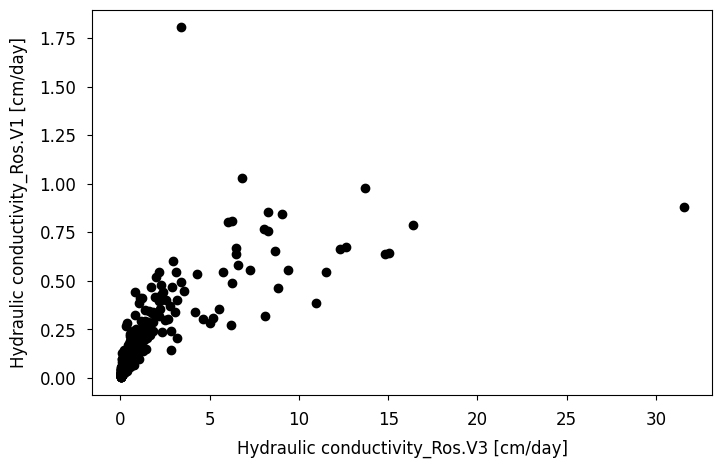

In [5]:
#Plotting hydraulic conductivity values obtained from Rosetta versions 1 and 3
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,5))
plt.xlabel('Hydraulic conductivity_Ros.V3 [cm/day]', fontsize=12, labelpad=8)
plt.ylabel('Hydraulic conductivity_Ros.V1 [cm/day]', fontsize=12, labelpad=8)
plt.tick_params(axis='both', which='major', labelsize=12,pad=8)
plt.tick_params(axis='both', which='minor', labelsize=12,pad=8)
plt.plot(K3, K1, 'ok')

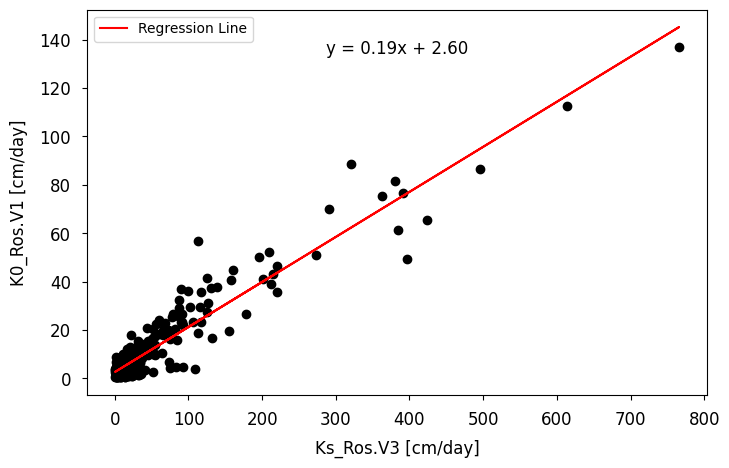

In [20]:
# Plotting K0 from Rosetta V1 versus Ks from Rosetta V3
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,5))
plt.xlabel('Ks_Ros.V3 [cm/day]', fontsize=12, labelpad=8)
plt.ylabel('K0_Ros.V1 [cm/day]', fontsize=12, labelpad=8)
plt.tick_params(axis='both', which='major', labelsize=12,pad=8)
plt.tick_params(axis='both', which='minor', labelsize=12,pad=8)
plt.plot(Ks_3, K0, 'ok')

# Linear regression
from scipy.stats import linregress

valid_indices = ~np.isnan(Ks_3) & ~np.isnan(K0)
x = Ks_3[valid_indices]
y = K0[valid_indices]

slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plotting the regression line
plt.plot(x, slope*x + intercept, '-r', label='Regression Line')

# Annotate the plot with the equation of the line
equation = f'y = {slope:.2f}x + {intercept:.2f}'
plt.text(0.5, 0.9, equation, ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)

plt.legend()
plt.show()

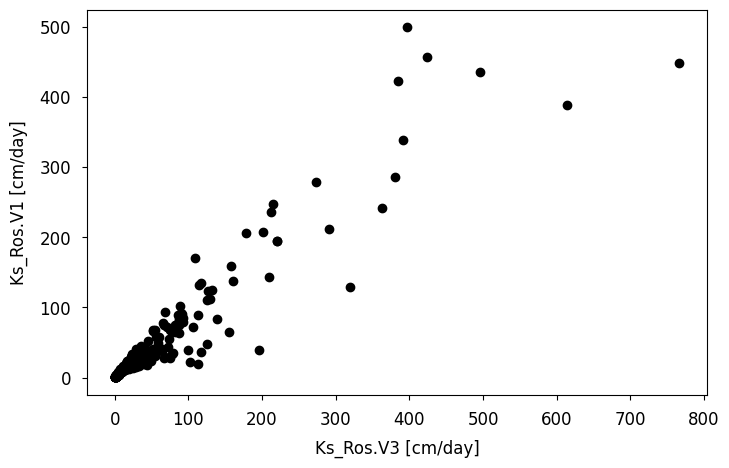

In [21]:
#Plotting Ks values from Rosetta versions 1 and 3
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,5))
plt.xlabel('Ks_Ros.V3 [cm/day]', fontsize=12, labelpad=8)
plt.ylabel('Ks_Ros.V1 [cm/day]', fontsize=12, labelpad=8)
plt.tick_params(axis='both', which='major', labelsize=12,pad=8)
plt.tick_params(axis='both', which='minor', labelsize=12,pad=8)
plt.plot(Ks_3, Ks_1, 'ok')